## Leveraging schemas for reproducible biomedical data analysis 
---

In this tutorial, we will use LaminDB to enhance the organization and reproducibility of an ML analysis. Specifically, we will explore:

- The role of schemas in maintaining dataset consistency.
- The importance of features and labels in structuring biological data.
- How to create and register features and labels in LaminDB.
- Enforcing schema adherence to improve findability and interoperability.
- How structured data management streamlines the analysis workflow.

It is split into multiple notebooks which can resemble multiple stages a dataset is processed in. 

- Introduction and querying raw data
- Preprocessing Raw data and some EDA
- ML Analysis and biological interpretation

By the end of this tutorial, you'll learn how to curate and structure biological datasets using LaminDB, enabling seamless integration of multiple experiments, improving dataset discoverability, and maintaining an efficient, reproducible data analysis pipeline.

### Our dataset: Single-cell RNA sequencing reveals the mechanism of human breast cancer metastasis
---

`Objective`: This dataset investigates the molecular changes associated with lymph node metastasis in breast cancer using single-cell RNA sequencing (scRNA-seq). By analyzing matched primary breast cancer (PC) tumors and lymph node (LN) metastases from five patients, the study aims to identify key transcriptional differences between primary and metastatic sites. The analysis seeks to uncover potential biomarkers, pathways, and cellular programs that drive the transition from primary tumors to metastatic disease in the lymph nodes.

`Reference`: [Xu K, Wang R, Chen Q, Liu Y et al. Microenvironment components and spatially resolved single-cell transcriptome atlas of breast cancer metastatic axillary lymph nodes.](https://www.sciengine.com/ABBS/doi/10.3724/abbs.2022131) 




We're interested in figuring out: What are the key transcriptomic features that drive the transition from primary tumor to lymph node metastasis in breast cancer?

To that end, we will walk-through the following steps:

- Extract latent representations from scRNA-seq data using scVI.
- Construct a bipartite cell-gene graph.
- Train a heterogeneous GNN for cell classification.
- Interpret results using Integrated Gradients (IG).

### Getting Raw Data

Regardless of the data source—whether a Nextflow, Snakemake, or Redun pipeline—we first register and ingest the raw data. This step ensures that anyone starting the analysis can easily access and use the raw data without redundancy. Instead of manually retrieving files, users can simply search for the raw artifact in the LaminDB Artifacts Registry and load the data seamlessly, ensuring consistency and reproducibility in the workflow.

Here, we will create an AnnData object from the raw data and register it as an artifact, making it easily accessible for downstream analysis. 

In [27]:
import lamindb as ln
import bionty as bt

In [28]:
ln.track()

→ loaded Transform('mI70CDrdZK310000'), re-started Run('6WZyqNus...') at 2025-03-06 13:22:30 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.0 lamindb==1.1a1 pandas==2.2.3 scanpy==1.11.0 scipy==1.14.1 tqdm==4.67.1


In [ ]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata
import scipy.sparse as sp
from tqdm import tqdm

In [ ]:
adata = ln.Artifact.get("9KD0HE9lVveLpvuI0000")

In [12]:
adata.describe()

Artifact .h5ad/AnnData
└── General
    ├── .uid = '9KD0HE9lVveLpvuI0000'
    ├── .key = 'data/prep_adata'
    ├── .size = 124511524
    ├── .hash = 'gnwU_GFFN_xIhtncrxu-tv'
    ├── .path = s3://lamindata/.lamindb/9KD0HE9lVveLpvuI0000.h5ad
    ├── .created_by = paupaiz
    └── .created_at = 2025-03-03 17:24:56

In [33]:
# read adata
adata = sc.read("/Users/paulinampaiz/Desktop/myLamin_local/data/adata_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 117481 × 17872
    obs: 'patient', 'site'

In [6]:
adata.var.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
SPP1,2923,0.430912,0.358312,97.511938,50624,10.832201,2907,True,1.060332,6.013085,7.134072
B2M,114032,13.144142,2.649301,2.935794,1544187,14.250009,106029,True,4.639525,3.853987,1.000000
IGLC2,27936,7.435526,2.132452,76.220836,873533,13.680302,27072,True,3.361647,7.955990,4.061160
IGLC3,12000,2.112044,1.135280,89.785582,248125,12.421692,11517,True,2.195756,7.512773,3.253199
CMC1,7777,0.083971,0.080631,93.380206,9865,9.196850,7676,True,0.437156,2.875771,0.787998


In [7]:
adata.obs.head()

,patient,site,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_genes
GGATAAGGGTCA-0,P1,primary,6931,8.843904,61662,11.029439,35.125361,43.456262,52.221790,64.303785,6931
CCGTGCGTACTG-0,P1,primary,5618,8.633909,39183,10.576024,33.233800,41.745145,51.570834,65.099661,5618
AGGTAACCTACG-0,P1,primary,5122,8.541495,29445,10.290313,31.991849,39.592461,48.972661,62.947869,5122
CTGTATAACCTA-0,P1,primary,4799,8.476371,25420,10.143331,33.674272,42.053501,50.955940,64.394178,4799
AAACAGGTTTGA-0,P1,primary,4634,8.441391,23312,10.056766,36.577728,44.753775,53.307310,66.090426,4634


In [34]:
adata_artifact = ln.Artifact.from_anndata(
    adata,
    description="breast metastasis"
).save()

In [35]:
ln.Artifact.df().head()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
2,NfPayTupzUQ5YEem0000,None,breast metastasis,.h5ad,dataset,AnnData,982219738,q4mdUBZZH_DE65t29RY5UG,None,117481,sha1-fl,True,False,1,1,None,None,True,2,2025-03-06 13:44:05.173000+00:00,1,None,1
1,fqDEKvRwg55UfKxG0000,None,breast metastasis,.h5ad,dataset,AnnData,124511524,AFTJoMzP5ERzpiMqjr1qR3,None,108038,sha1-fl,True,False,1,1,None,None,True,2,2025-03-05 21:28:29.211000+00:00,1,None,1


In [36]:
adata_artifact.describe()

Artifact .h5ad/AnnData
└── General
    ├── .uid = 'NfPayTupzUQ5YEem0000'
    ├── .size = 982219738
    ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
    ├── .n_observations = 117481
    ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/NfPayTupzUQ5YEem0000.h5ad
    ├── .created_by = paupaiz
    ├── .created_at = 2025-03-06 07:44:05
    └── .transform = 'Schema_001.ipynb'

### We can annotate our Artifact with Labels and Features
---

#### Labels

In [37]:
## Data status represents Raw or Filtered Data
processing_stage = ln.ULabel(name="Processing Stage", is_type=True).save()

→ returning existing ULabel record with same name: 'Processing Stage'


In [38]:
## Add Raw as ULabel
raw_status = ln.ULabel(
    name="Raw", type=processing_stage
).save()

## Add Filetred as ULabel
filtered_status = ln.ULabel(
    name="Filtered", type=processing_stage
).save()

→ returning existing ULabel record with same name: 'Raw'
→ returning existing ULabel record with same name: 'Filtered'


In [39]:
# We can now add this raw Label to the artifact
adata_artifact.ulabels.add(raw_status)

In [40]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'NfPayTupzUQ5YEem0000'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/NfPayTupzUQ5YEem0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:44:05
│   └── .transform = 'Schema_001.ipynb'
└── Labels
    └── .ulabels                    ULabel                     Raw

Similary we can add ULabels from bionty registry

In [41]:
# Tissue
tissue_breast = bt.Tissue.from_source(name="breast").save()
tissue_lymph = bt.Tissue.from_source(name="lymph node").save()

adata_artifact.tissues.add(tissue_breast)
adata_artifact.tissues.add(tissue_lymph)

# Disease 
disease = bt.Disease.from_source(name="breast cancer").save()
adata_artifact.diseases.add(disease)

In [42]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'NfPayTupzUQ5YEem0000'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/NfPayTupzUQ5YEem0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:44:05
│   └── .transform = 'Schema_001.ipynb'
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

#### Features

We can also annotate datasets by features.

In [43]:
ln.Feature(name="experiment", dtype=str).save()
ln.Feature(name="disease", dtype=bt.Disease).save()
ln.Feature(name="author", dtype=str).save()

→ returning existing Feature record with same name: 'experiment'
→ returning existing Feature record with same name: 'disease'
→ returning existing Feature record with same name: 'author'


Feature(uid='knv7wRW1vWML', name='author', dtype='str', array_rank=0, array_size=0, created_by_id=1, run_id=2, space_id=1, created_at=2025-03-05 21:29:23 UTC)

In [44]:
# we can now annotate our artifact
adata_artifact.features.add_values(
    {
        "experiment": "Breast Cancer scRNA-seq Experiment",
        "disease": disease,
        "author": "Xu K"
    }
)

In [45]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'NfPayTupzUQ5YEem0000'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/NfPayTupzUQ5YEem0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:44:05
│   └── .transform = 'Schema_001.ipynb'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
│       experiment                  str                        Breast Cancer scRNA-seq Experiment       
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

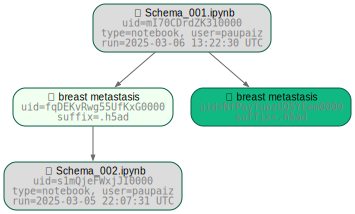

In [46]:
adata_artifact.view_lineage()

### Search and Query the dataset
---
with our artifact well annotated we can now easily search for it in the registry

In [26]:
#or
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
1,fqDEKvRwg55UfKxG0000,None,breast metastasis,.h5ad,dataset,AnnData,124511524,AFTJoMzP5ERzpiMqjr1qR3,None,108038,sha1-fl,True,False,1,1,None,None,True,2,2025-03-05 21:28:29.211000+00:00,1,None,1
